# 4. SHAP 
- SHapely Additive exPlanation

- https://blog.dominodatalab.com/shap-lime-python-libraries-part-1-great-explainers-pros-cons/

## 1. Import Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
house = pd.read_csv('kc_house_data.csv')
house.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
0      5650     1.0           0     0     ...          7        1180   
1      7242     2.0           0     0     ...          7        2170   
2     10000     1.0           0     0     ...          6         770   
3      5000     1.0           0     0     ...          7        1050   
4      8080     1.0           0     0     ...          8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [14]:
house.drop(['id','date','zipcode','lat','long'], axis=1, inplace=True)

In [15]:
feature_columns = list(house.columns.difference(['price']))

X = house[feature_columns]
y = house['price']

print(X.shape)

(21613, 15)


In [16]:
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.3, random_state=42)

## 2. Modeling : LightGBM

In [47]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error as mse

lgb_param = {'max_depth' : 10,
            'learning_rate':0.01,
            'n_estimators' : 1000,
            'objective' : 'regression'} # REGRESSION 이므로

lgbm = lgb.LGBMRegressor(random_state=42, **lgb_param)
lgbm.fit(train_x,train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=42, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [48]:
# Prediction
lgb_predict = lgbm.predict(test_x)

print("RMSE : {}".format(sqrt(mse(lgb_predict, test_y))))

RMSE : 195975.30035150063


## 3. SHAP value 
- 'feature 별 영향도' 파악

In [24]:
import shap
import skimage

explainer = shap.TreeExplainer(lgb_model)

In [26]:
shap_values = explainer.shap_values(test_x)
shap_values

array([[ 2.16917966e+03, -1.05860029e+03,  2.23375844e+04, ...,
        -2.19742430e+03, -5.21281621e+04, -1.44005273e+03],
       [ 1.00560633e+04, -9.53863266e+03,  7.60096772e+04, ...,
        -3.06711574e+03, -2.93177785e+04, -1.09746404e+03],
       [-3.17055069e+04, -1.31038921e+03, -2.24945305e+04, ...,
        -1.47562064e+04, -1.10111483e+05, -5.76004264e+03],
       ...,
       [-1.27556950e+04,  4.54552634e+02, -5.39118069e+03, ...,
        -2.01115077e+03,  4.90546892e+04, -9.35702671e+02],
       [-8.67576923e+03, -1.33667287e+02, -8.02435430e+03, ...,
        -2.49064495e+03,  2.02591617e+05, -7.15370013e+02],
       [-9.32340553e+02, -1.53656496e+03, -8.63796463e+03, ...,
        -1.97721192e+03, -6.39284483e+04, -1.66541000e+03]])

In [28]:
print(test_x.shape)
print(shap_values.shape)

(6484, 15)
(6484, 15)


### 해석 ( 1번째 instance )
- sqrt_above ( 상층 평수가 2070인 것이 집값에 "긍정적"인 영향을 끼쳤다 )
- yr_built ( 1986년에 지어졌다는 사실이 집값에 "부정적"인 영향을 끼쳤다 ) 

In [29]:
# javascript 초기화 ( graph 초기화 )
shap.initjs()

# 1번째 instance에 대해서
shap.force_plot(explainer.expected_value, shap_values[0,:], test_x.iloc[0,:])

### 해석 ( 전체 dataset ) ~ ex) feature 'grade'
- grade가 높으면 높을 수록, output에 "긍정적"인 영향을 끼침
- yr_built보면, 집이 최근에 지어졌다고 output이 반드시 큰 것은 아님!

In [31]:
# 전체 dataset에 대해서
shap.force_plot(explainer.expected_value, shap_values, test_x) 

C:\Users\samsung\Anaconda3\lib\site-packages\shap\plots\force.py:141: UserWarning: shap.force_plot is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.force_plot is slow for many thousands of rows, try subsampling your data.")


## 변수 중요도 summary

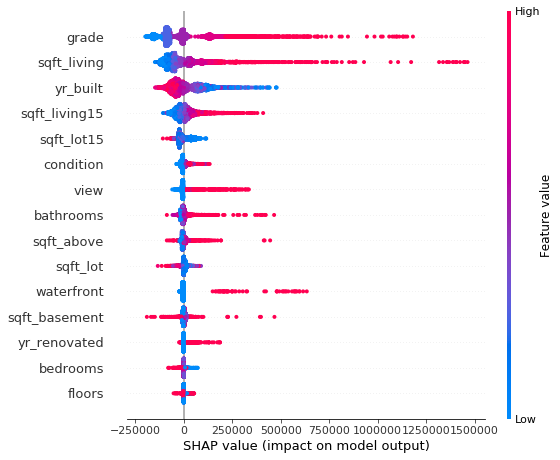

In [32]:
# 색깔이 고르게 섞여있으면 중요변수 X
shap.summary_plot(shap_values, test_x)

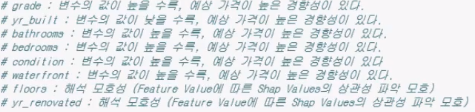

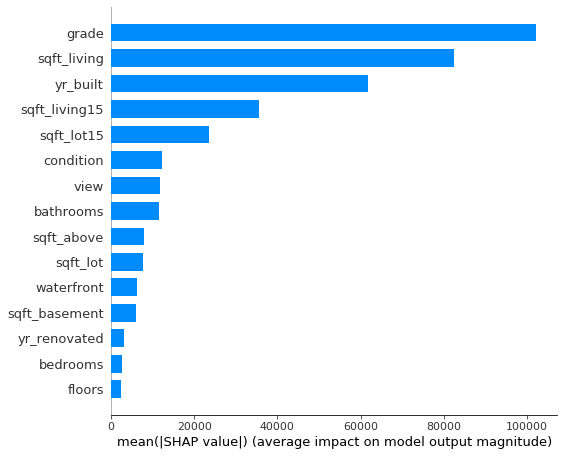

In [36]:
# 중요도 파악
# (영향의 정도 ( 절대값! 긍,부정 무시하고 ) )
shap.summary_plot(shap_values, test_x, plot_type = 'bar')

### '특정' 변수 중요도 ( dependence_plot )

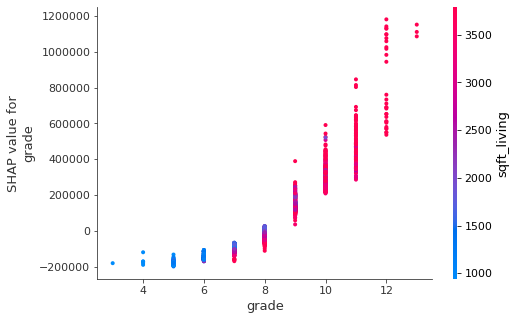

In [37]:
shap.dependence_plot('grade', shap_values, test_x)

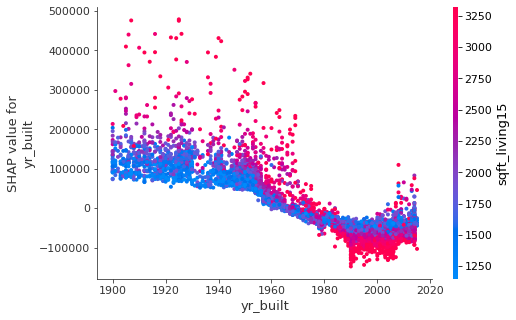

In [38]:
shap.dependence_plot('yr_built', shap_values, test_x)